In [1]:
using HydroTools, Plots, Test

  0.397095 seconds (369.75 k allocations: 29.597 MiB, 12.46% gc time, 79.49% compilation time)
  0.406078 seconds (382.24 k allocations: 30.247 MiB, 12.18% gc time, 79.90% compilation time)


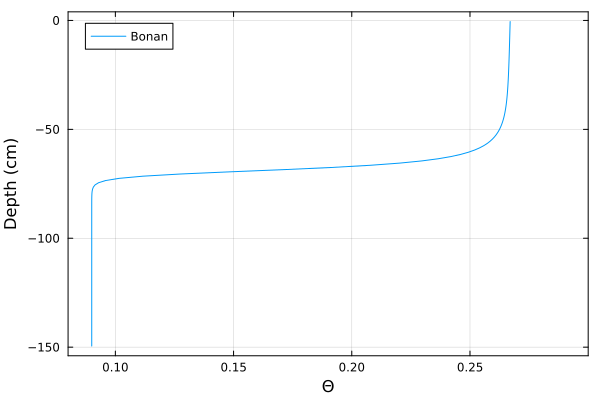

In [2]:
n = 150
dz = ones(n)
z, z₋ₕ, z₊ₕ, dz₊ₕ = soil_depth_init(dz)

soil_texture = 1
param = (soil_texture=1,
  θ_res=0.075, θ_sat=0.287,
  α=0.027, n=3.96, m=1, K_sat=34 / 3600)

θ = fill(0.1, n)
ψ = matric_potential(θ, param; method="van_Genuchten")

θ0 = 0.267
ψ0 = matric_potential(θ0, param; method="van_Genuchten")

dt = 5
ntim = 0.8 * 3600 / dt
sink = ones(n) * 0.3 / 86400 # [cm s⁻¹]

(; θ, ψ, ψ0, dz, dt, param, sink)


@time begin
  # % --- Initialize accumulators for water balance check
  sum_in = 0
  sum_out = 0
  sum_store = 0

  # --- Time stepping loop: NTIM iterations with a time step of DT seconds
  @time for itim = 1:ntim
    hour = itim * (dt / 86400 * 24)
    # @printf("hour = %8.3f\n", hour)
    # Calculate soil moisture
    Q0, QN, dθ, err = soil_moisture!(θ, ψ, ψ0, dz, dt, param; sink)
    
    # % Sum fluxes for relative mass balance error
    sum_in += abs(Q0) * dt
    sum_out += abs(QN) * dt
    sum_store += dθ
  end

  # @test sum_in == 11.810243822643141
  # @test sum_out == 0.10508872215771699
  # @test sum_store == 11.704825251924781
end

gr(framestyle=:box)
plot(θ, z; label="Bonan", xlabel="θ", ylabel="Depth (cm)", xlims=(0.08, 0.3))


In [3]:
using JLD2
jldsave("data/output_bonan.jld2"; θ=θ, ψ)